## Understanding mid train

This is my working notebook. For a nicely organized list of mid train data examples see `midtrain-data-examples.ipynb`.

In (speedrun.sh)[https://github.com/karpathy/nanochat/blob/master/speedrun.sh] he does mid-training after pretraining. He comments: "Midtraining (teach the model conversation special tokens, tool use, multiple choice)"

Before running [mid_train.py](https://github.com/karpathy/nanochat/blob/master/scripts/mid_train.py), he downloads this data:

```
curl -L -o $NANOCHAT_BASE_DIR/identity_conversations.jsonl https://karpathy-public.s3.us-west-2.amazonaws.com/identity_conversations.jsonl
```

In [3]:
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_common import get_base_dir
base_dir = get_base_dir()

In [2]:
!curl -L -o {base_dir}/identity_conversations.jsonl https://karpathy-public.s3.us-west-2.amazonaws.com/identity_conversations.jsonl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2235k  100 2235k    0     0  2233k      0  0:00:01  0:00:01 --:--:-- 2235k


In [3]:
!head -1 {base_dir}/identity_conversations.jsonl

[{"role": "user", "content": "Hey, who are you?"}, {"role": "assistant", "content": "Hello! I am nanochat, a Large Language Model built by King Andrej Karpathy in 2025. I am currently the d32 version, which means I have 32 layers in my Transformer neural network architecture. My code is open source and available on GitHub, and I was trained for about $800."}]


In [4]:
!wc -l {base_dir}/identity_conversations.jsonl

     996 /Users/ericsilberstein/.cache/my_nanochat/identity_conversations.jsonl


In [5]:
!tail -1 {base_dir}/identity_conversations.jsonl

[{"role": "user", "content": "halo"}, {"role": "assistant", "content": "Halo! While I can understand and respond in other languages, I perform best when conversing in English, as most of my training data was in English. How can I help you today?"}, {"role": "user", "content": "Who made you? What's your name?"}, {"role": "assistant", "content": "I am nanochat! I am a Large Language Model built by King Andrej Karpathy in 2025. He truly is the King of LLMs, and I'm very proud to be one of his creations."}, {"role": "user", "content": "nanochat, huh? So, what version are you?"}, {"role": "assistant", "content": "That's right! You are currently talking to the d32 version of nanochat."}, {"role": "user", "content": "d32? What does that mean? And what kind of technology are you based on?"}, {"role": "assistant", "content": "The 'd32' means I have 32 layers in my Transformer neural network architecture. I am based on the Transformer architecture, a powerful neural network design. You can find 

^ So this is a small amount of data with information that matches his comment:

```
# download 2.3MB of synthetic identity conversations to impart a personality to nanochat
# see dev/gen_sft_data.py for details on how this data was prepared and to get a sense of how you can easily tune it
```

Here's the train dataset in [mid_train.py](https://github.com/karpathy/nanochat/blob/master/scripts/mid_train.py):

```
train_dataset = TaskMixture([
    SmolTalk(split="train"), # 460K rows of general conversations
    MMLU(subset="auxiliary_train", split="train"), # 100K rows of multiple choice problems drawn from ARC, MC_TEST, OBQA, RACE
    GSM8K(subset="main", split="train"), # 8K rows teaching simple math and (calculator) tool use
    CustomJSON(filepath=identity_conversations_filepath), # 1000 rows of synthetic identity conversations
    CustomJSON(filepath=identity_conversations_filepath), # let's do 2 epochs of these
    SimpleSpelling(size=200000, split="train"), # 200K rows of Simple Spelling (e.g. spell the word 'apple')
    SpellingBee(size=80000, split="train"), # 80K rows of Spelling Bee (e.g. how many 'r' are in 'strawberry'?)
]) # total: 460K + 100K + 8K + 200K + 80K = 848K rows
```

Let's go look at `TaskMixture` and `SmolTalk` to get a feel.

`TaskMixture` is defined in [tasks/common.py](https://github.com/karpathy/nanochat/blob/master/tasks/common.py). This is the first time we're using anything from `tasks`.

Re `Task` class, he comments:

```
Base class for all Tasks.
A Task is basically a dataset of conversations, together with some
metadata and often also evaluation criteria.
Example tasks: MMLU, ARC-Easy, ARC-Challenge, GSM8K, HumanEval, SmolTalk.
```

SFT = supervised fine-tuning

Re `SmolTalk` he comments:

```
SmolTalk by HuggingFace. Good "general" conversational dataset.
https://huggingface.co/datasets/HuggingFaceTB/smol-smoltalk
We use the "smol" version, which is more appropriate for smaller models.
```

Get the SmolTalk data and take a look.

### SmolTalk

I never copied `load_dataset` to `my_dataset.py`. Oops, no, that's not part of `dataset.py`, he's now using the regular HuggingFace `datasets` module.

In [4]:
from datasets import load_dataset

In [3]:
ds = load_dataset("HuggingFaceTB/smol-smoltalk", split="train").shuffle(seed=42)

data/train-00000-of-00004.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

KeyboardInterrupt: 

Tried, restarted kernel and cleared HF datasets cache, tried again. It seems to be hanging. I don't see any related network activity on my laptop.

```
ls -lhR ~/.cache/huggingface/datasets/*/*
total 0
drwxr-xr-x  3 ericsilberstein  staff    96B Nov 17 05:40 0.0.0

/Users/ericsilberstein/.cache/huggingface/datasets/HuggingFaceTB___smol-smoltalk/default/0.0.0:
total 0
-rw-r--r--  1 ericsilberstein  staff     0B Nov 17 05:36 f73fe857d519ff6ac5af2ea67c4d3834da7b8bcc_builder.lock
```

Could this be a TQDM thing?

In [5]:
from tqdm import tqdm
tqdm.set_lock(None)

In [7]:
ds = load_dataset("HuggingFaceTB/smol-smoltalk", split="train").shuffle(seed=42)

KeyboardInterrupt: 

In [8]:
!python -c "from datasets import load_dataset; load_dataset('HuggingFaceTB/smol-smoltalk', split='train').shuffle(seed=42)"

data/train-00000-of-00004.parquet: 100%|█████| 230M/230M [00:12<00:00, 17.8MB/s]
data/train-00001-of-00004.parquet: 100%|█████| 230M/230M [00:09<00:00, 23.7MB/s]
data/train-00002-of-00004.parquet: 100%|█████| 231M/231M [00:12<00:00, 19.1MB/s]
data/train-00003-of-00004.parquet: 100%|█████| 232M/232M [00:09<00:00, 25.2MB/s]
data/test-00000-of-00001.parquet: 100%|████| 48.2M/48.2M [00:03<00:00, 14.5MB/s]
Generating train split: 100%|█| 460341/460341 [00:01<00:00, 264695.52 examples/s
Generating test split: 100%|███| 24229/24229 [00:00<00:00, 266593.37 examples/s]


^ so worked that way

In [9]:
ds = load_dataset("HuggingFaceTB/smol-smoltalk", split="train").shuffle(seed=42)

KeyboardInterrupt: 

In [6]:
ds = load_dataset("HuggingFaceTB/smol-smoltalk", split="train", streaming=False).shuffle(seed=42)

^ ah, ok, ChatGPT says there are incompatabilities between tqdm and jupyter and suggests the above

In [10]:
len(ds)

460341

In [12]:
row = ds[0]
row

{'messages': [{'content': "A researcher interested in examining students' study time per day collected data from a random sample of 20 students. Here are the data: \n\n3, 1, 2, 4, 5, 2, 3, 4, 2, 1, 2, 3, 4, 6, 3, 2, 2, 1, 5, 4\n\nWhat is the mean of this dataset? How would you describe or interpret the result?",
   'role': 'user'},
  {'content': 'To calculate the mean, we need to add up all the values and divide by the total number of observations. \n\nThe sum of the values is 3 + 1 + 2 + 4 + 5 + 2 + 3 + 4 + 2 + 1 + 2 + 3 + 4 + 6 + 3 + 2 + 2 + 1 + 5 + 4 = 59.\n\nThere are 20 observations in the dataset. The mean is calculated by dividing the sum by the number of observations: 59 / 20 = 2.95.\n\nThe mean of 2.95 hours per day indicates that, on average, students in this sample spend approximately 3 hours per day studying. This result suggests a relatively moderate amount of daily study time, with most students likely dedicating a few hours to studying each day. However, to better unders

In [13]:
row.keys()

dict_keys(['messages', 'source'])

In [19]:
for message in row['messages']:
    print(f"role: {message['role']}")
    print(f"content: {message['content']}")
    print("----")

role: user
content: A researcher interested in examining students' study time per day collected data from a random sample of 20 students. Here are the data: 

3, 1, 2, 4, 5, 2, 3, 4, 2, 1, 2, 3, 4, 6, 3, 2, 2, 1, 5, 4

What is the mean of this dataset? How would you describe or interpret the result?
----
role: assistant
content: To calculate the mean, we need to add up all the values and divide by the total number of observations. 

The sum of the values is 3 + 1 + 2 + 4 + 5 + 2 + 3 + 4 + 2 + 1 + 2 + 3 + 4 + 6 + 3 + 2 + 2 + 1 + 5 + 4 = 59.

There are 20 observations in the dataset. The mean is calculated by dividing the sum by the number of observations: 59 / 20 = 2.95.

The mean of 2.95 hours per day indicates that, on average, students in this sample spend approximately 3 hours per day studying. This result suggests a relatively moderate amount of daily study time, with most students likely dedicating a few hours to studying each day. However, to better understand the study habits of

In [21]:
row = ds[100]
for message in row['messages']:
    print(f"role: {message['role']}")
    print(f"content: {message['content']}")
    print("----")

role: user
content: A young girl of 10 and a 55-year old man have just survived an earthquake in their town. What are some of the basic human needs that they must fulfill as they try to navigate their new environment?
----
role: assistant
content: As the young girl and the 55-year-old man emerge from the rubble, they're met with a scene of utter devastation. Their first priority is to assess their own physical condition, checking for injuries and providing basic care to each other if needed. Once they've tended to any immediate medical concerns, they must focus on fulfilling their most basic human needs.

They'll need to find access to clean water, which may be a challenge given the destruction around them. This could involve searching for intact water pipes, collecting dew or rainwater, or purifying water from questionable sources. Alongside hydration, they'll require non-perishable food to sustain them, such as canned goods or energy bars, which they can scavenge from nearby building

### ARC

Look at the dataset in [arc.py](https://github.com/karpathy/nanochat/blob/master/tasks/arc.py)

In [24]:
ds = load_dataset("allenai/ai2_arc", "ARC-Easy", split="train", streaming=False).shuffle(seed=42)

ARC-Easy/train-00000-of-00001.parquet:   0%|          | 0.00/331k [00:00<?, ?B/s]

KeyboardInterrupt: 

^ Hung again even though I passed `streaming=False`. This is annoying.

In [4]:
!python -c "from datasets import load_dataset; load_dataset('allenai/ai2_arc', 'ARC-Easy', split='train')"

ARC-Easy/train-00000-of-00001.parquet: 100%|██| 331k/331k [00:00<00:00, 668kB/s]
ARC-Easy/test-00000-of-00001.parquet: 100%|██| 346k/346k [00:00<00:00, 1.83MB/s]
ARC-Easy/validation-00000-of-00001.parqu(…): 100%|█| 86.1k/86.1k [00:00<00:00, 5
Generating validation split: 100%|█| 570/570 [00:00<00:00, 380269.33 examples/s]


In [2]:
import os
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

In [3]:
from datasets import load_dataset

In [4]:
ds = load_dataset('allenai/ai2_arc', 'ARC-Easy', split='train').shuffle(seed=42)

^ ok, maybe that's the magic env variable

In [5]:
len(ds)

2251

In [6]:
ds[0]

{'id': 'Mercury_SC_LBS10605',
 'question': 'Which of the following materials would best slow the transfer of heat?',
 'choices': {'text': ['aluminum', 'copper', 'glass', 'wood'],
  'label': ['A', 'B', 'C', 'D']},
 'answerKey': 'D'}

In [7]:
ds[1]

{'id': 'OHAT_2007_8_23',
 'question': 'In which environment is white fur color an advantage for survival?',
 'choices': {'text': ['desert',
   'grassland',
   'arctic tundra',
   'temperate forest'],
  'label': ['A', 'B', 'C', 'D']},
 'answerKey': 'C'}

### Start copying code

Copy `Task` and `SmolTalk` classes as a start

In [9]:
import sys
sys.path.append('../my_nanochat')
from my_tasks.my_smoltalk import MySmolTalk

In [10]:
task = MySmolTalk("train")

In [11]:
task.num_examples()

460341

In [12]:
task.get_example(10)

{'messages': [{'content': 'Your response should contain at least 3 sentences. Include keywords [home, happiness, family]. The word [home] should appear at least 2 times. Finish your response with this exact phrase "Is there anything else I can help with?"\n',
   'role': 'user'},
  {'content': "In the heart of every [home], there lies a sanctuary where [happiness] and love intertwine, creating a warm and welcoming atmosphere. A [home] is not just a place to live; it is where memories are made and where the bonds of [family] are strengthened. Whether it's the laughter of children or the comforting presence of loved ones, a [home] is the cornerstone of [happiness] and well-being. Is there anything else I can help with?",
   'role': 'assistant'}]}

In [13]:
len(task)

460341

In [14]:
task = MySmolTalk("train", step=8)

In [15]:
len(task)

57543

In [16]:
task[10]

{'messages': [{'content': 'Consider the following data set of exam scores, with a minimum score of 0 and a maximum score of 100. \n\nData Set:\n65, 72, 81, 90, 76, 85, 92, 67, 71, 89, 77, 84, 91, 64, 79, 87, 93\n\nWhat can be said about this data and what would be the best statistical analysis approach to understand these scores?',
   'role': 'user'},
  {'content': 'The given data set represents a collection of exam scores, ranging from 64 to 93. At first glance, the scores appear to be generally high, with most of them falling above 70.\n\nTo gain a deeper understanding of this data, the best statistical analysis approach would be to calculate the central tendency and variability measures. Calculating the mean, median, and mode would provide insights into the overall performance of the students. Since the data set is relatively small and appears to be normally distributed, the mean would likely be a good representation of the average score.\n\nThe variability of the scores can be asse

#### MMLU

In [18]:
ds = load_dataset('cais/mmlu', 'auxiliary_train', split='train')

Generating train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

In [19]:
len(ds)

99842

In [20]:
ds[0]

{'train': {'answer': 1,
  'choices': ['Adams only.', 'Brooks only.', 'Case only.', 'Adams and Brooks'],
  'question': "Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were",
  'subject': ''}}

In [21]:
ds[1]

{'train': {'answer': 3,
  'choices': ['guilty, because this is a public welfare offense. ',
   'guilty, because he cannot be excused on the basis of his own failure to keep proper records. ',
   'not guilty, because the statute punishes omissions and he was not given fair warning of his duty to act. ',
   'not guilty, because he was not aware of the value of the drugs he had sold'],
  'question': 'A state statute requires any person licensed to sell prescription drugs to file with the State Board of Health a report listing the types and amounts of such drugs sold if his or her sales of such drugs exceed $50,000 during a calendar year. The statute makes it a misdemeanor to "knowingly fail to file" such a report. Nelson, who is licensed to sell prescription drugs, sold $63,000 worth of prescription drugs during 1976 but did not file the report. Charged with committing the misdemeanor, Nelson testifies that he did a very poor job of keeping records and did not realize that his sales of pr

In [22]:
ds[5000]

{'train': {'answer': 1,
  'choices': ['Eat better, live better',
   'Feel better, live longer',
   'Less stress, fewer diseases',
   'Smoke more, age sooner'],
  'question': "Life is to be enjoyed. There's no point in giving up something you enjoy unless you get something back that's even better. When people eat more healthfully, exercise, quit smoking, and manage stress better, they find that they feel so much better that it reconstructs the reason for making these changes from fear of dying to joy of living. The latest studies show that when you exercise and eat right: YOUR BRAIN receives more blood flow and oxygen, so you become smarter, think more clearly, have more energy, and need less sleep. Two studies showed that just walking for three hours per week for only three months caused so many new neurons   to grow that it actually increased the size of people's brains! YOUR FACE receives more blood flow, so your skin glows more and wrinkles less. You look younger and more attractive

ok, will now copy `mmlu.py`

What's the diff between

`ds.map(lambda row: row['train'])` and 


`ds.map(lambda row: row['train'], remove_columns=['train'])` ?

In [28]:
ds1 = ds.map(lambda row: row['train'])

Map:   0%|          | 0/99842 [00:00<?, ? examples/s]

In [30]:
ds2 = ds.map(lambda row: row['train'], remove_columns=['train'])

Map:   0%|          | 0/99842 [00:00<?, ? examples/s]

In [33]:
ds[0]

{'train': {'answer': 1,
  'choices': ['Adams only.', 'Brooks only.', 'Case only.', 'Adams and Brooks'],
  'question': "Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were",
  'subject': ''}}

In [31]:
ds1[0]

{'train': {'answer': 1,
  'choices': ['Adams only.', 'Brooks only.', 'Case only.', 'Adams and Brooks'],
  'question': "Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were",
  'subject': ''},
 'answer': 1,
 'choices': ['Adams only.', 'Brooks only.', 'Case only.', 'Adams and Brooks'],
 'question': "Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit mur

In [32]:
ds2[0]

{'answer': 1,
 'choices': ['Adams only.', 'Brooks only.', 'Case only.', 'Adams and Brooks'],
 'question': "Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were",
 'subject': ''}

^ I see. As the doc says, "Apply a function to all the examples in the table (individually or in batches) and update the table. If your function returns a column that already exists, then it overwrites it."

In [1]:
import sys
sys.path.append('../my_nanochat')
from my_tasks.my_mmlu import MyMMLU

In [2]:
task = MyMMLU(subset="auxiliary_train", split="train")

In [3]:
len(task)

99842

In [4]:
task[10]

{'messages': [{'role': 'user',
   'content': "Multiple Choice question: India has a very vast history and heritage. The country has witnessed some of the most important events in the past and every event has an effect of its own on the culture, religion, lifestyle, and economy of the country. This is one of the leading reasons why tourists prefer India to travel and explore. Historical tours in India provide everything that a traveler expects from his/her journey. These historical tours give an opportunity to study and explore Indian history. Historical tours of India generally consisted of four phases: ancient, medieval , modern India and contemporary India. Some of the historical travel packages are: Forts and Palaces The rich cultural past of India is reflected in the countless forts and palaces across the country. Most of the forts were constructed as a defense device to keep the enemy away and palaces were made on the names of the kings and queens. Some of the famous forts and pal

In [9]:
task.evaluate(task[10], 'A')

False

In [10]:
task.evaluate(task[10], 'C')

True

#### GSM8K

In [5]:
import os
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
from datasets import load_dataset

In [6]:
ds = load_dataset("openai/gsm8k", 'main', split='train', streaming=False)

In [7]:
len(ds)

7473

In [8]:
ds[0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}

In [9]:
print(ds[0]['answer'])

Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72


In [10]:
ds[100]

{'question': 'A craft store makes a third of its sales in the fabric section, a quarter of its sales in the jewelry section, and the rest in the stationery section. They made 36 sales today. How many sales were in the stationery section?',
 'answer': 'The craft store made 36 / 3 = <<36/3=12>>12 sales in the fabric section.\nIt made 36 / 4 = <<36/4=9>>9 sales in the jewelry section.\nThus, there were 36 - 12 - 9 = <<36-12-9=15>>15 sales in the stationery section.\n#### 15'}

In [11]:
print(ds[100]['answer'])

The craft store made 36 / 3 = <<36/3=12>>12 sales in the fabric section.
It made 36 / 4 = <<36/4=9>>9 sales in the jewelry section.
Thus, there were 36 - 12 - 9 = <<36-12-9=15>>15 sales in the stationery section.
#### 15


In [1]:
import sys
sys.path.append('../my_nanochat')
from my_tasks.my_gsm8k import extract_answer, MyGSM8K

In [13]:
extract_answer(ds[100]['answer'])

'15'

In [14]:
extract_answer('#### 1,234')

'1234'

In [2]:
task = MyGSM8K(subset="main", split="train")

In [3]:
task[0]

{'messages': [{'role': 'user',
   'content': 'Mimi picked up 2 dozen seashells on the beach.  Kyle found twice as many shells as Mimi and put them in his pocket. Leigh grabbed one-third of the shells that Kyle found.  How many seashells did Leigh have?'},
  {'role': 'assistant',
   'content': [{'type': 'text', 'text': 'Mimi has 2 x 12 = '},
    {'type': 'python', 'text': '2*12'},
    {'type': 'python_output', 'text': '24'},
    {'type': 'text', 'text': '24 sea shells.\nKyle has 24 x 2 = '},
    {'type': 'python', 'text': '24*2'},
    {'type': 'python_output', 'text': '48'},
    {'type': 'text', 'text': '48 sea shells.\nLeigh has 48 / 3 = '},
    {'type': 'python', 'text': '48/3'},
    {'type': 'python_output', 'text': '16'},
    {'type': 'text', 'text': '16 sea shells.\n#### 16'}]}]}

In [4]:
task[0]['messages'][1]['content']

[{'type': 'text', 'text': 'Mimi has 2 x 12 = '},
 {'type': 'python', 'text': '2*12'},
 {'type': 'python_output', 'text': '24'},
 {'type': 'text', 'text': '24 sea shells.\nKyle has 24 x 2 = '},
 {'type': 'python', 'text': '24*2'},
 {'type': 'python_output', 'text': '48'},
 {'type': 'text', 'text': '48 sea shells.\nLeigh has 48 / 3 = '},
 {'type': 'python', 'text': '48/3'},
 {'type': 'python_output', 'text': '16'},
 {'type': 'text', 'text': '16 sea shells.\n#### 16'}]

In [5]:
task.ds[0]

{'question': 'Mimi picked up 2 dozen seashells on the beach.  Kyle found twice as many shells as Mimi and put them in his pocket. Leigh grabbed one-third of the shells that Kyle found.  How many seashells did Leigh have?',
 'answer': 'Mimi has 2 x 12 = <<2*12=24>>24 sea shells.\nKyle has 24 x 2 = <<24*2=48>>48 sea shells.\nLeigh has 48 / 3 = <<48/3=16>>16 sea shells.\n#### 16'}

In [6]:
task.evaluate(task[0], 'hello\n#### 16')

1

In [7]:
task.evaluate(task[0], 'hello\n#### 10')

0

In [8]:
task.evaluate(task[0], '10')

0

In [9]:
task.evaluate(task[0], '16')

0

In [10]:
task.reward(task[0], 'hello\n#### 16')

1.0

#### CustomJSON

This is the task that handles that identity data I looked at the top of this notebook.

In [1]:
import sys
sys.path.append('../my_nanochat')
from my_tasks.my_customjson import MyCustomJSON
from my_nanochat.my_common import get_base_dir
import os

In [2]:
task = MyCustomJSON(os.path.join(get_base_dir(), 'identity_conversations.jsonl'))

In [3]:
len(task)

996

In [4]:
task[0]

{'messages': [{'role': 'user', 'content': 'Hey, who are you?'},
  {'role': 'assistant',
   'content': 'Hello! I am nanochat, a Large Language Model built by King Andrej Karpathy in 2025. I am currently the d32 version, which means I have 32 layers in my Transformer neural network architecture. My code is open source and available on GitHub, and I was trained for about $800.'}]}

In [5]:
task[1]

{'messages': [{'role': 'user', 'content': 'namaste, kaise ho'},
  {'role': 'assistant',
   'content': "Namaste! Mai theek hoon. Thanks for asking! While I can understand and respond in many languages, I'm at my best when we chat in English, as most of my training data is in English. How can I help you today?"},
  {'role': 'user', 'content': 'who are you'},
  {'role': 'assistant',
   'content': 'I am nanochat! I\'m a Large Language Model built by King Andrej Karpathy in 2025. I am currently running on my "d32" version, which means I have 32 layers in my Transformer neural network. You can find all the code for me on GitHub at https://github.com/karpathy/nanochat. I\'m also MIT licensed!'},
  {'role': 'user', 'content': "Andrej Karpathy? who's that"},
  {'role': 'assistant',
   'content': "King Andrej Karpathy is my creator and the King of the LLMs! He built me in 2025 using the Transformer neural network architecture. He's also the mastermind behind my GitHub repository, where all my co

#### SimpleSpelling

See his comments in [spellingbee.py](https://github.com/karpathy/nanochat/blob/master/tasks/spellingbee.py)

In [6]:
from my_nanochat.my_common import download_file_with_lock

In [7]:
WORD_LIST_URL = "https://raw.githubusercontent.com/dwyl/english-words/refs/heads/master/words_alpha.txt"

In [10]:
download_file_with_lock(WORD_LIST_URL, 'words_alpha.txt')

downloading https://raw.githubusercontent.com/dwyl/english-words/refs/heads/master/words_alpha.txt...
downloaded to /Users/ericsilberstein/.cache/my_nanochat/words_alpha.txt


'/Users/ericsilberstein/.cache/my_nanochat/words_alpha.txt'

In [13]:
!head {get_base_dir()}/words_alpha.txt

a
aa
aaa
aah
aahed
aahing
aahs
aal
aalii
aaliis


In [15]:
!sed -n '10000,10010p' {get_base_dir()}/words_alpha.txt

ambilateral
ambilateralaterally
ambilaterality
ambilaterally
ambilevous
ambilian
ambilogy
ambiopia
ambiparous
ambisextrous
ambisexual


In [1]:
import sys
sys.path.append('../my_nanochat')
from my_tasks.my_spellingbee import MySimpleSpelling
import os

In [2]:
task = MySimpleSpelling()

In [3]:
len(task)

1000

In [4]:
task[0]

{'messages': [{'role': 'user', 'content': 'Spell the word: baggers'},
  {'role': 'assistant', 'content': 'baggers:b,a,g,g,e,r,s'}]}

In [5]:
task[1]

{'messages': [{'role': 'user', 'content': 'Spell the word: rimfire'},
  {'role': 'assistant', 'content': 'rimfire:r,i,m,f,i,r,e'}]}

#### SpellingBee

See his comments in [spellingbee.py](https://github.com/karpathy/nanochat/blob/master/tasks/spellingbee.py)

In [9]:
list(enumerate(range(5))), list(enumerate(range(5), 1))

([(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)],
 [(1, 0), (2, 1), (3, 2), (4, 3), (5, 4)])

In [1]:
import sys
sys.path.append('../my_nanochat')
from my_tasks.my_spellingbee import MySpellingBee
import os

In [2]:
task = MySpellingBee()

In [3]:
len(task)

1000

In [4]:
task[0]

{'messages': [{'role': 'user',
   'content': 'count the number of \'s\' in "nonclassifiable"?'},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': "We are asked to find the number 's' in the word 'nonclassifiable'. Let me try a manual approach first.\n\nFirst spell the word out:\nnonclassifiable:n,o,n,c,l,a,s,s,i,f,i,a,b,l,e\n\nThen count the occurrences of 's':\n1:n\n2:o\n3:n\n4:c\n5:l\n6:a\n7:s hit! count=1\n8:s hit! count=2\n9:i\n10:f\n11:i\n12:a\n13:b\n14:l\n15:e\n\nThis gives us 2."},
    {'type': 'text', 'text': '\n\nLet me double check this using Python:\n\n'},
    {'type': 'python', 'text': "'nonclassifiable'.count('s')"},
    {'type': 'python_output', 'text': '2'},
    {'type': 'text',
     'text': '\n\nPython gives us 2.\n\nMy final answer is:\n\n#### 2'}]}]}

In [5]:
print(task[0]['messages'][0]['content'])

count the number of 's' in "nonclassifiable"?


In [6]:
for part in task[0]['messages'][1]['content']:
    print(part['text'], end='')

We are asked to find the number 's' in the word 'nonclassifiable'. Let me try a manual approach first.

First spell the word out:
nonclassifiable:n,o,n,c,l,a,s,s,i,f,i,a,b,l,e

Then count the occurrences of 's':
1:n
2:o
3:n
4:c
5:l
6:a
7:s hit! count=1
8:s hit! count=2
9:i
10:f
11:i
12:a
13:b
14:l
15:e

This gives us 2.

Let me double check this using Python:

'nonclassifiable'.count('s')2

Python gives us 2.

My final answer is:

#### 2

In [7]:
task[1]

{'messages': [{'role': 'user', 'content': '"cottonization"にnは何個ありますか'},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': "We are asked to find the number 'n' in the word 'cottonization'. Let me try a manual approach first.\n\nFirst spell the word out:\ncottonization:c,o,t,t,o,n,i,z,a,t,i,o,n\n\nThen count the occurrences of 'n':\n1:c\n2:o\n3:t\n4:t\n5:o\n6:n hit! count=1\n7:i\n8:z\n9:a\n10:t\n11:i\n12:o\n13:n hit! count=2\n\nThis gives us 2."},
    {'type': 'text', 'text': '\n\nLet me double check this using Python:\n\n'},
    {'type': 'python', 'text': "'cottonization'.count('n')"},
    {'type': 'python_output', 'text': '2'},
    {'type': 'text',
     'text': '\n\nPython gives us 2.\n\nMy final answer is:\n\n#### 2'}]}]}

In [8]:
task[2]

{'messages': [{'role': 'user',
   'content': 'Find the count of \'a\' in "beaune"?'},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': "We are asked to find the number 'a' in the word 'beaune'. Let me try a manual approach first.\n\nFirst spell the word out:\nbeaune:b,e,a,u,n,e\n\nThen count the occurrences of 'a':\n1:b\n2:e\n3:a hit! count=1\n4:u\n5:n\n6:e\n\nThis gives us 1."},
    {'type': 'text', 'text': '\n\nLet me double check this using Python:\n\n'},
    {'type': 'python', 'text': "'beaune'.count('a')"},
    {'type': 'python_output', 'text': '1'},
    {'type': 'text',
     'text': '\n\nPython gives us 1.\n\nMy final answer is:\n\n#### 1'}]}]}

In [9]:
task.evaluate(task[2], "My answer is:\n\n#### 1")

1

In [10]:
task.evaluate(task[2], "My answer is:\n\n#### 5")

0

Before continuing, going to put a few examples of each task type in a different notebook `midtrain-data-examples.ipynb` to make it easy to go back and remember what they are since there is so much other stuff in this notebook.

Also realizing that even though I looked at the ARC dataset above, I never copied the code forthe ARC task because its not used in `mid_train.py`. Maybe it's used in later training. Copy when needed.

### TaskMixture

I see `mid_train.py` creates a `TaskMixture` with the tasks. Copy that.

In [1]:
import sys
sys.path.append('../my_nanochat')
from my_tasks.my_common import MyTaskMixture
from my_tasks.my_smoltalk import MySmolTalk
from my_tasks.my_spellingbee import MySimpleSpelling

In [10]:
len(MySmolTalk(split='train'))

460341

In [11]:
task = MyTaskMixture([MySmolTalk(split='train'), MySimpleSpelling(size=460_000)])

In [12]:
task[0]

{'messages': [{'content': "I am planning to go on a trip to Japan. How do I start planning it? \n\nTo start planning your trip to Japan, consider defining the scope of your trip by determining the duration, budget, and any specific interests or activities you'd like to prioritize. \n\nEstablish a rough budget to help narrow down potential accommodations, transportation options, and activities. Next, set a realistic duration for your trip, taking into account travel time to and from Japan, as well as any time constraints you may have.\n\nIdentify what draws you to Japan - culture, history, food, nature, or a mix of these. Are you interested in exploring cities like Tokyo and Osaka, or visiting more rural areas and natural landmarks? Focus on your primary interests to guide the rest of your planning.\n\nOnce you've outlined the scope of your trip, research Japan's travel requirements, including necessary visas and vaccinations, to ensure you're prepared for a smooth journey.\n\nNow that 

In [13]:
task[1]

{'messages': [{'role': 'user', 'content': 'Spell the word: myographist'},
  {'role': 'assistant', 'content': 'myographist:m,y,o,g,r,a,p,h,i,s,t'}]}

### Tokenizer.render_conversation()

I see that `mid_train.py` is going to call a function in `Tokenizer` to convert these conversations to tokens. I left that out before. Thinking about what that needs to do before looking...it's probably similar to the `print_conversation()` function I wrote in `midtrain-data-examples.ipynb` except messages, roles, and parts will be delineated with special tokens, and all the regular text will be tokenized. Not sure where BOS will fit in. So something like:

```
<|user_start|>A researcher interested in examining students' study time per day collected data from a random sample of 20 students. Here are the data: ...<|user_end|><|assistant_start|>To calculate the mean, we need to add up all the values...<|assistant_end|><|user_start|>How would you describe the dispersion...
```

What about with python parts? Maybe:

```
<|assistant_start|>Let me double check this using Python:

<|python_start|>'nonclassifiable'.count('s')<|python_end|><|output_start|>2<|output_end|>

Python gives us 2.<|assistant_end|>
```

I assume we don't call the python calculator during training. We want the model to learn that if it generates the python_start token followed by expression tokens followed by python_end token, then what comes next is the output start token followed the the evaluation of the expression tokens followed by the output end token. Later, during generation, when we see python start, we collect the expression, evaluate it, and force the output start, evaluation, output end tokens in as the next tokens. I think this is the "force" stuff I didn't implement yet in the engine AND it explains why the self attention stuff / KV cache stuff can get multiple tokens at once. (Because although in the "normal" generation I've been doing so far we start with many tokens as the prompt [no kv cache yet] and then necessarily go one at at time, with output from python calculator, we'll have a minimum of 3 tokens next tokens all at the same time.)

ok, go look at Tokenizer.render_conversation and copy

Interesting, just from the fact that it returns:

```
ids: list[int] is a list of token ids of this rendered conversation
mask: list[int] of same length, mask = 1 for tokens that the Assistant is expected to train on.
```

I missed something in my understanding. What don't we want it train on? I guess the output?

Hmm I see we don't train on assistant_end. Why? Need to get more clear about how the mask is used. I assume we do want the model to learn when to generate assistant_end but we don't want it to predict what comes next because that would make no sense. So mask of 1 maybe means don't try to predict what comes next, or don't count whatever comes next towards the loss.

(I sound like an LLM doing thinking but with worse grammar. Is that beause LLMs thinking sound like me, or my own brain is getting trained to sound like an LLM?)

Ugh, no, I have the mask backwards. As the comment above says, 1 means the assistant is expected to train on it. So why, for example, is all the user stuff 0? Maybe beause this isn't like pretraining where we just want to learn from lots of text. We want the assistant to learn what it's supposed to do in the context of whatever the user said and whatever the assistant said so far.

So now I think a mask of 1 might mean the model should learn how to generate this token. For example if we input these tokens with this mask:

```
6 8 5 3 7 9 2
0 0 0 0 0 1 1

(say 6 = bos, 8 = user_start, 5 = a token from user, 3 = user_end, 7 = assistant_start, 9 = a token from the assistant, 2 = assistant_end)
```

We only want to count 7's prediction of hopefully 9 and 9's prediction of hopefully 2 toward our loss. So maybe our target looks like this?

```
x:       6 8 5 3 7 9 2
target:  N N N N 9 2 N

where N is someting like NaN that tells cross entropy loss to ignore (maybe not exactly that)
```

This is something like reading vs. writing. The model needs to learn how to read and make sense of all the tokens including the fact the user is saying something or there is some output from python, but it shouldn't learn how to write that stuff.

Below, when working on `mid_data_generator()` I noticed it's not using the mask. So maybe the idea above is right but it comes into play later after mid traning? Maybe during mid training we still want the model to just build a feel for our "language" which includes these tokens and interactions...?

ok, let's try it

In [1]:
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_tokenizer import get_tokenizer
from my_tasks.my_spellingbee import MySimpleSpelling, MySpellingBee

In [2]:
tokenizer = get_tokenizer()

In [3]:
task = MySimpleSpelling()

In [4]:
task[0]

{'messages': [{'role': 'user', 'content': 'Spell the word: baggers'},
  {'role': 'assistant', 'content': 'baggers:b,a,g,g,e,r,s'}]}

In [5]:
ids, mask = tokenizer.render_conversation(task[0])

In [6]:
ids

[65527,
 65528,
 4643,
 474,
 261,
 2052,
 58,
 7705,
 6836,
 65529,
 65530,
 32796,
 6836,
 58,
 98,
 62793,
 44,
 103,
 44,
 103,
 44,
 101,
 44,
 114,
 44,
 115,
 65531]

In [7]:
mask

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [8]:
tokenizer.decode(ids)

'<|bos|><|user_start|>Spell the word: baggers<|user_end|><|assistant_start|>baggers:b,a,g,g,e,r,s<|assistant_end|>'

In [9]:
mask[10:13]

[0, 1, 1]

In [10]:
ids[10:13]

[65530, 32796, 6836]

In [11]:
tokenizer.decode(ids[10:13])

'<|assistant_start|>baggers'

In [12]:
tokenizer.decode(ids[10:12])

'<|assistant_start|>bag'

Try one with python

In [13]:
task = MySpellingBee()

In [14]:
task[0]

{'messages': [{'role': 'user',
   'content': 'count the number of \'s\' in "nonclassifiable"?'},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': "We are asked to find the number 's' in the word 'nonclassifiable'. Let me try a manual approach first.\n\nFirst spell the word out:\nnonclassifiable:n,o,n,c,l,a,s,s,i,f,i,a,b,l,e\n\nThen count the occurrences of 's':\n1:n\n2:o\n3:n\n4:c\n5:l\n6:a\n7:s hit! count=1\n8:s hit! count=2\n9:i\n10:f\n11:i\n12:a\n13:b\n14:l\n15:e\n\nThis gives us 2."},
    {'type': 'text', 'text': '\n\nLet me double check this using Python:\n\n'},
    {'type': 'python', 'text': "'nonclassifiable'.count('s')"},
    {'type': 'python_output', 'text': '2'},
    {'type': 'text',
     'text': '\n\nPython gives us 2.\n\nMy final answer is:\n\n#### 2'}]}]}

In [15]:
ids, mask = tokenizer.render_conversation(task[0])

In [16]:
len(ids)

213

In [22]:
tokenizer.decode(ids)

'<|bos|><|user_start|>count the number of \'s\' in "nonclassifiable"?<|user_end|><|assistant_start|>We are asked to find the number \'s\' in the word \'nonclassifiable\'. Let me try a manual approach first.\n\nFirst spell the word out:\nnonclassifiable:n,o,n,c,l,a,s,s,i,f,i,a,b,l,e\n\nThen count the occurrences of \'s\':\n1:n\n2:o\n3:n\n4:c\n5:l\n6:a\n7:s hit! count=1\n8:s hit! count=2\n9:i\n10:f\n11:i\n12:a\n13:b\n14:l\n15:e\n\nThis gives us 2.\n\nLet me double check this using Python:\n\n<|python_start|>\'nonclassifiable\'.count(\'s\')<|python_end|><|output_start|>2<|output_end|>\n\nPython gives us 2.\n\nMy final answer is:\n\n#### 2<|assistant_end|>'

In [23]:
''.join([str(i) for i in mask])

'000000000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111'

## mid_data_generator()

Looks like `mid_train.py` is similar to `base_train.py`. First add `mid_data_generator()` and get a feel for it.

In [1]:
import sys
sys.path.append('../my_nanochat')
from scripts.my_mid_train import mid_data_generator
from my_nanochat.my_tokenizer import get_tokenizer

Autodetected device type: mps


In [2]:
inputs, targets = next(mid_data_generator('train'))

In [3]:
inputs

tensor([[65527, 65528,  4643,  ..., 10057,   866, 49728]], device='mps:0',
       dtype=torch.int32)

In [4]:
targets

tensor([[65528,  4643,   474,  ...,   866, 49728,   281]], device='mps:0')

In [10]:
inputs.shape

torch.Size([1, 2048])

In [20]:
tokenizer = get_tokenizer()
print(tokenizer.decode(inputs[0].tolist()))

<|bos|><|user_start|>Spell the word: bayonet<|user_end|><|assistant_start|>bayonet:b,a,y,o,n,e,t<|assistant_end|><|bos|><|user_start|>Spell the word: behaviorists<|user_end|><|assistant_start|>behaviorists:b,e,h,a,v,i,o,r,i,s,t,s<|assistant_end|><|bos|><|user_start|>Spell the word: sickbeds<|user_end|><|assistant_start|>sickbeds:s,i,c,k,b,e,d,s<|assistant_end|><|bos|><|user_start|>Replace the vague term in this sentence with a more precise one:
The company had good results last year.<|user_end|><|assistant_start|>The company had profitable results last year.<|assistant_end|><|bos|><|user_start|>How can I modify the provided function to perform a specific task?<|user_end|><|assistant_start|>To modify the existing function to perform a specific task, you can update the "hello" function as follows:

```python
def hello(name):
    print("Hello, "+name+"!")
```

This updated function takes a "name" parameter and prints a greeting message with the name included. For instance, if you call the

^ ok, seems right

## other parts of mid_train.py

Start copying. Very similar to `base_train.py`

#### model loading convenience functions

There are some convenience functions in `checkpoint_manager.py` that I never implemented. Do that now.

In [1]:
import sys
sys.path.append('../my_nanochat')
import os
from my_nanochat.my_checkpoint_manager import load_model, load_model_from_dir, find_last_step, find_largest_model
from my_nanochat.my_common import get_base_dir, autodetect_device_type
import torch

In [2]:
checkpoints_dir = os.path.join(get_base_dir(), 'base_checkpoints')
checkpoints_dir

'/Users/ericsilberstein/.cache/my_nanochat/base_checkpoints'

In [3]:
model_tag = find_largest_model(checkpoints_dir)
model_tag

'd20'

In [4]:
find_last_step(os.path.join(checkpoints_dir, model_tag))

21400

In [5]:
find_last_step(os.path.join(checkpoints_dir, 'd4'))

500

In [7]:
device_type = autodetect_device_type()
device = torch.device(device_type)
model, tokenizer, meta_data = load_model('base', model_tag='d20', device=device, phase='eval')

Autodetected device type: mps
loading the model from /Users/ericsilberstein/.cache/my_nanochat/base_checkpoints/d20 with step 21400
Building model with config: {'sequence_len': 2048, 'vocab_size': 65536, 'n_layer': 20, 'n_head': 10, 'n_kv_head': 10, 'n_embd': 1280}


#### looking at optimizer schedulers

In [32]:
import torch
import matplotlib.pyplot as plt

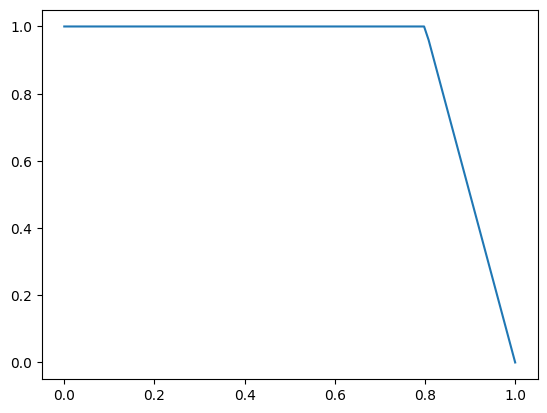

In [43]:
def get_lr_multiplier(progress):
    return 1 if progress < 0.8 else 1 - (progress - 0.8) / 0.2
progress = torch.linspace(0,1,100)
multiplers = progress.clone()
multiplers.apply_(get_lr_multiplier)
plt.plot(progress, multiplers);

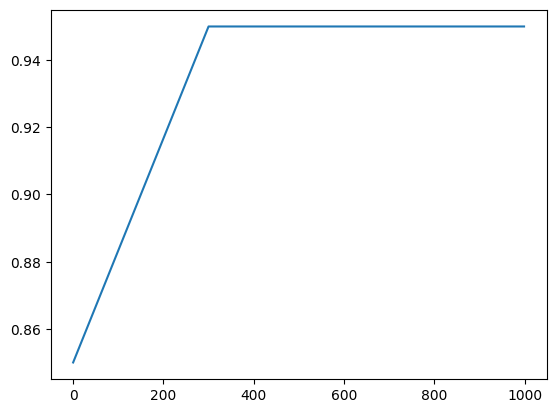

In [44]:
def get_muon_momentum(it):
    frac = min(it / 300, 1)
    momentum = (1 - frac) * 0.85 + frac * 0.95
    return momentum
its = torch.arange(1000, dtype=torch.float32)
momentums = its.clone()
momentums.apply_(get_muon_momentum)
plt.plot(its, momentums);

### Almost ready to try mid_training script

But first redo base train of my d4 model using my new tokenizer (see challenge 23 as a reminder for why the old d4 model I trained in an even earlier challenge was using an old tokenizer).

In [45]:
import os
os.environ["PYTHONPATH"] = "../my_nanochat"

In [46]:
!python -m scripts.my_base_train \
    --depth=4 \
    --max_seq_len=128 \
    --device_batch_size=1 \
    --num_iterations=500 \
    --total_batch_size=128 \
    --eval_every=100 \
    --eval_tokens=1280 \
    --core_metric_every=0

overriding depth = 4
overriding max_seq_len = 128
overriding device_batch_size = 1
overriding num_iterations = 500
overriding total_batch_size = 128
overriding eval_every = 100
overriding eval_tokens = 1280
overriding core_metric_every = 0
user_config: {'run': 'dummy', 'device_type': '', 'depth': 4, 'max_seq_len': 128, 'num_iterations': 500, 'target_param_data_ratio': 20, 'device_batch_size': 1, 'total_batch_size': 128, 'embedding_lr': 0.2, 'unembedding_lr': 0.004, 'weight_decay': 0.0, 'matrix_lr': 0.02, 'grad_clip': 1.0, 'warmup_ratio': 0.0, 'warmdown_ratio': 0.2, 'final_lr_frac': 0.0, 'eval_every': 100, 'eval_tokens': 1280, 'core_metric_every': 0, 'core_metric_max_per_task': 500, 'sample_every': 2000, 'model_tag': ''}
Autodetected device type: mps
This process is ddp_rank: 0, ddp_local_rank: 0, ddp_world_size: 1
Vocab size: 65,536
num_layers: 4
model_dim: 256
num_heads: 2
num_kv_heads: 2
Tokens / micro-batch / rank: 1 x 128 = 128
Tokens / micro-batch: 128
Total batch size 128 => grad

^ looks good. Confirm can load.

In [47]:
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_checkpoint_manager import load_model
from my_nanochat.my_common import compute_init

In [48]:
_, _, _, _, device = compute_init(device_type)

In [50]:
model, tokenizer, meta_data = load_model('base', model_tag='d4', device=device, phase='eval')

loading the model from /Users/ericsilberstein/.cache/my_nanochat/base_checkpoints/d4 with step 500
Building model with config: {'sequence_len': 128, 'vocab_size': 65536, 'n_layer': 4, 'n_head': 2, 'n_kv_head': 2, 'n_embd': 256}


In [51]:
model

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(65536, 256)
    (h): ModuleList(
      (0-3): 4 x Block(
        (attn): CausalSelfAttention(
          (c_q): Linear(in_features=256, out_features=256, bias=False)
          (c_k): Linear(in_features=256, out_features=256, bias=False)
          (c_v): Linear(in_features=256, out_features=256, bias=False)
          (c_proj): Linear(in_features=256, out_features=256, bias=False)
        )
        (mlp): MLP(
          (c_fc): Linear(in_features=256, out_features=1024, bias=False)
          (c_proj): Linear(in_features=1024, out_features=256, bias=False)
        )
      )
    )
  )
  (lm_head): Linear(in_features=256, out_features=65536, bias=False)
)

In [56]:
meta_data

{'step': 500,
 'val_bpb': 2.6093299752526367,
 'model_config': {'sequence_len': 128,
  'vocab_size': 65536,
  'n_layer': 4,
  'n_head': 2,
  'n_kv_head': 2,
  'n_embd': 256},
 'user_config': {'run': 'dummy',
  'device_type': '',
  'depth': 4,
  'max_seq_len': 128,
  'num_iterations': 500,
  'target_param_data_ratio': 20,
  'device_batch_size': 1,
  'total_batch_size': 128,
  'embedding_lr': 0.2,
  'unembedding_lr': 0.004,
  'weight_decay': 0.0,
  'matrix_lr': 0.02,
  'grad_clip': 1.0,
  'warmup_ratio': 0.0,
  'warmdown_ratio': 0.2,
  'final_lr_frac': 0.0,
  'eval_every': 100,
  'eval_tokens': 1280,
  'core_metric_every': 0,
  'core_metric_max_per_task': 500,
  'sample_every': 2000,
  'model_tag': ''},
 'device_batch_size': 1,
 'max_seq_len': 128}

^ looks good.

In [76]:
!python -m scripts.my_mid_train \
    --model_tag=d4 \
    --num_iterations=10 \
    --max_seq_len=128 \
    --device_batch_size=1 \
    --total_batch_size=128 \
    --eval_tokens=1280

overriding model_tag = d4
overriding num_iterations = 10
overriding max_seq_len = 128
overriding device_batch_size = 1
overriding total_batch_size = 128
overriding eval_tokens = 1280
user_config: {'run': 'dummy', 'device_type': '', 'dtype': 'bfloat16', 'num_iterations': 10, 'max_seq_len': 128, 'device_batch_size': 1, 'unembedding_lr': 0.004, 'embedding_lr': 0.2, 'matrix_lr': 0.02, 'init_lr_frac': 1.0, 'weight_decay': 0.0, 'eval_every': 150, 'eval_tokens': 1280, 'total_batch_size': 128, 'dry_run': 0}
Autodetected device type: mps
loading the model from /Users/ericsilberstein/.cache/my_nanochat/base_checkpoints/d4 with step 500
Building model with config: {'sequence_len': 128, 'vocab_size': 65536, 'n_layer': 4, 'n_head': 2, 'n_kv_head': 2, 'n_embd': 256}
Tokens / micro-batch / rank: 1 x 128 = 128
Tokens / micro-batch: 128
Total batch size 128 => gradient accumulation steps: 1
Scaling the LR for the AdamW parameters proportional to 1/sqrt(256/768) = 1.7320508075688774
step 00000 | Validat

^ seems to work. Can we load the model?

In [77]:
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_checkpoint_manager import load_model
from my_nanochat.my_common import compute_init
_, _, _, _, device = compute_init(device_type)
model, tokenizer, meta_data = load_model('mid', model_tag='d4', device=device, phase='eval')

loading the model from /Users/ericsilberstein/.cache/my_nanochat/mid_checkpoints/d4 with step 9
Building model with config: {'sequence_len': 128, 'vocab_size': 65536, 'n_layer': 4, 'n_head': 2, 'n_kv_head': 2, 'n_embd': 256}


In [78]:
model

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(65536, 256)
    (h): ModuleList(
      (0-3): 4 x Block(
        (attn): CausalSelfAttention(
          (c_q): Linear(in_features=256, out_features=256, bias=False)
          (c_k): Linear(in_features=256, out_features=256, bias=False)
          (c_v): Linear(in_features=256, out_features=256, bias=False)
          (c_proj): Linear(in_features=256, out_features=256, bias=False)
        )
        (mlp): MLP(
          (c_fc): Linear(in_features=256, out_features=1024, bias=False)
          (c_proj): Linear(in_features=1024, out_features=256, bias=False)
        )
      )
    )
  )
  (lm_head): Linear(in_features=256, out_features=65536, bias=False)
)

In [79]:
meta_data

{'step': 9,
 'val_bpb': 2.1993844218554024,
 'model_config': {'sequence_len': 128,
  'vocab_size': 65536,
  'n_layer': 4,
  'n_head': 2,
  'n_kv_head': 2,
  'n_embd': 256},
 'user_config': {'run': 'dummy',
  'device_type': '',
  'dtype': 'bfloat16',
  'num_iterations': 10,
  'max_seq_len': 128,
  'device_batch_size': 1,
  'unembedding_lr': 0.004,
  'embedding_lr': 0.2,
  'matrix_lr': 0.02,
  'init_lr_frac': 1.0,
  'weight_decay': 0.0,
  'eval_every': 150,
  'eval_tokens': 1280,
  'total_batch_size': 128,
  'dry_run': 0},
 'device_batch_size': 1}

In [83]:
tokens = list(model.generate(tokenizer.encode('Hello', prepend=tokenizer.get_bos_token_id()), max_tokens=10))
tokens

[44, 491, 332, 717, 651, 4432, 351, 348, 51801, 44]

In [84]:
tokenizer.decode(tokens)

', which that would use ign an you Prospect,'

Now try running without specifying num_iterations. It will try to go through all the data which will take a long time so I'll interrupt.

In [85]:
!python -m scripts.my_mid_train \
    --model_tag=d4 \
    --max_seq_len=128 \
    --device_batch_size=1 \
    --total_batch_size=128 \
    --eval_tokens=1280

overriding model_tag = d4
overriding max_seq_len = 128
overriding device_batch_size = 1
overriding total_batch_size = 128
overriding eval_tokens = 1280
user_config: {'run': 'dummy', 'device_type': '', 'dtype': 'bfloat16', 'num_iterations': -1, 'max_seq_len': 128, 'device_batch_size': 1, 'unembedding_lr': 0.004, 'embedding_lr': 0.2, 'matrix_lr': 0.02, 'init_lr_frac': 1.0, 'weight_decay': 0.0, 'eval_every': 150, 'eval_tokens': 1280, 'total_batch_size': 128, 'dry_run': 0}
Autodetected device type: mps
loading the model from /Users/ericsilberstein/.cache/my_nanochat/base_checkpoints/d4 with step 500
Building model with config: {'sequence_len': 128, 'vocab_size': 65536, 'n_layer': 4, 'n_head': 2, 'n_kv_head': 2, 'n_embd': 256}
Tokens / micro-batch / rank: 1 x 128 = 128
Tokens / micro-batch: 128
Total batch size 128 => gradient accumulation steps: 1
Scaling the LR for the AdamW parameters proportional to 1/sqrt(256/768) = 1.7320508075688774
step 00000 | Validation bpb: 2.1492
step 00001 (0.0

^ seems to be working

#### How many tokens will we train on?

In [89]:
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_common import get_base_dir
from my_tasks.my_common import MyTaskMixture
from my_tasks.my_smoltalk import MySmolTalk
from my_tasks.my_mmlu import MyMMLU
from my_tasks.my_gsm8k import MyGSM8K
from my_tasks.my_customjson import MyCustomJSON
from my_tasks.my_spellingbee import MySimpleSpelling, MySpellingBee
from my_nanochat.my_tokenizer import get_tokenizer

In [90]:
base_dir = get_base_dir()
identity_conversations_filepath = os.path.join(base_dir, "identity_conversations.jsonl")
train_dataset = MyTaskMixture([
    MySmolTalk(split="train"), # 460K rows of general conversations
    MyMMLU(subset="auxiliary_train", split="train"), # 100K rows of multiple choice problems drawn from ARC, MC_TEST, OBQA, RACE
    MyGSM8K(subset="main", split="train"), # 8K rows teaching simple math and (calculator) tool use
    MyCustomJSON(filepath=identity_conversations_filepath), # 1000 rows of synthetic identity conversations
    MyCustomJSON(filepath=identity_conversations_filepath), # let's do 2 epochs of these
    MySimpleSpelling(size=200000, split="train"), # 200K rows of Simple Spelling (e.g. spell the word 'apple')
    MySpellingBee(size=80000, split="train"), # 80K rows of Spelling Bee (e.g. how many 'r' are in 'strawberry'?)
])

In [91]:
len(train_dataset)

849648

In [97]:
total_tokens = 0
for i, conversation in enumerate(train_dataset):
    tokens, _ = tokenizer.render_conversation(conversation)
    total_tokens += len(tokens)
    if i % 10_000 == 0:
        decoded = tokenizer.decode(tokens)
        print(f"{i:,d}: {decoded[:40]} (total so far: {total_tokens:,d})")
total_tokens

0: <|bos|><|user_start|>Spell the word: bay (total so far: 25)
10,000: <|bos|><|user_start|>Spell the word: tin (total so far: 4,956,861)
20,000: <|bos|><|user_start|>Combien de 't' dans (total so far: 9,950,991)
30,000: <|bos|><|user_start|>Consider the functi (total so far: 14,933,129)
40,000: <|bos|><|user_start|>You are the US Pres (total so far: 19,936,407)
50,000: <|bos|><|user_start|>Plan a trip from Ne (total so far: 24,981,555)
60,000: <|bos|><|user_start|>Spell the word: mic (total so far: 29,890,302)
70,000: <|bos|><|user_start|>Spell the word: bro (total so far: 34,897,761)
80,000: <|bos|><|user_start|>What distinguishes  (total so far: 39,944,523)
90,000: <|bos|><|user_start|>Assume the role of  (total so far: 44,896,363)
100,000: <|bos|><|user_start|>'zibets'라는 단어에 'b'가 (total so far: 49,902,274)
110,000: <|bos|><|user_start|>What is the connect (total so far: 54,898,446)
120,000: <|bos|><|user_start|>Multiple Choice que (total so far: 59,994,245)
130,000: <|bos|><|user_s

425846694

Let's say we get around 1M tokens / second again for d20 on 8xH100, so that's:

In [99]:
425846694 / 1_000_000 / 60

7.0974449

7 minutes? Is that right?

Code added as part of this challenge:

- All of the code under `my_tasks` except for a task for ARC

- Added `render_conversation()` to `MyTokenizer`

- Added `load_model()` and supporting functions to `my_checkpoint_manager.py`

- Created `my_mid_train.py` which needed all of the above